# 03 - Interactive Viz


### IMPORTANT: To see the maps and analyse this notebook, go to the link below (NB Viewer)
https://nbviewer.jupyter.org/github/Amaumaury/ada-2017/blob/master/Homework3.ipynb

### Imports, functions

In [72]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import json
import folium
import matplotlib.pyplot as plt

# Makes a folium color map
def make_folium_map(json_map_path, object_path,  color_func, vmin, vmax, colors_table,location, zoom_start, legend_name  ):

    cantons_path = os.path.join('', json_map_path)

    topo_json_data = json.load(open(cantons_path))
    m = folium.Map(location=location, zoom_start=zoom_start)
    folium.TopoJson(
        topo_json_data, 
        object_path=object_path,
        style_function=lambda feature: {
            'fillColor': color_func(feature['id']),
            'fillOpacity': 0.9,
            'line_opacity':0.3,
            'weight': 0.4,

            }
        ).add_to(m)
    linear = folium.colormap.StepColormap( colors=colors_table, vmin=vmin, vmax=vmax,  caption=legend_name).add_to(m)
    
    # If you get an error try this line instead
    #linear = folium.StepColormap( colors=colors_table, vmin=vmin, vmax=vmax,  caption=legend_name).add_to(m)

    return m;

## I - Europe
### Load the Europe Unemployment Data
The Data is from  eurostat from Q2 2017, showing countries and unemployment rate in csv format.
1. Load the data.
2. Keep only 2017Q2 rate (the newest one)
3. Keep only TOTAL (exclude sex)
4. Delete the staticts for European union as a whole (first 6 rows)

In [51]:
ue_df = pd.read_csv('hw3_data/lfsq_urgan_1_Data.csv', header = 0)

# Keep only 2017Q2 rate (the newest one)
# Keep only TOTAL (exclude sex)
# Keep only GEO and VALUE information
# Delete the staticts for European union as a whole (first 6)
ue_df = ue_df[ue_df['TIME'] == '2017Q2' ][ue_df['SEX'] == 'Total' ][['GEO', 'Value']][6:]

ue_df.head()

/Users/combes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,GEO,Value
1071,Belgium,7.0
1074,Bulgaria,6.3
1077,Czech Republic,3.0
1080,Denmark,5.5
1083,Germany (until 1990 former territory of the FRG),3.8


### Clean the data
- Add ISO2 country codes manually
- Add missing country codes as Nan values (needed for the map)

In [52]:
# Adding ISO2 country codes 
ue_df['COUNTRY_CODE'] = ['BE', 'BG', 'CZ', 'DK', 'DE', 'EE', 'IE', 'GR', 'ES', 'FR', 'HR', 'IT', 'CY', 'LV', 'LT', 'LU', 'HU', 'MT', 'NL', 'AT', 'PL', 'PT' , 'RO', 'SI', 'SK', 'FI', 'SE', 'GB', 'IS', 'NO', 'CH', 'MK', 'TR']

# now we need to add missing country codes 
values_undefined = ['AZ','AL','AM','BA','GE','IL','BY','LI','FO','AD','MC','ME','MD','UA','SM','RS','VA','RU']
for name_val in values_undefined:
    ue_df = ue_df.append( {'GEO':name_val, 'Value': np.NaN, 'COUNTRY_CODE':name_val}, ignore_index = True)

ue_df.head()

,GEO,Value,COUNTRY_CODE
0,Belgium,7.0,BE
1,Bulgaria,6.3,BG
2,Czech Republic,3.0,CZ
3,Denmark,5.5,DK
4,Germany (until 1990 former territory of the FRG),3.8,DE


### Exploratory Data Analysis
Plot bar plot to Compare different european counntries with Switzerland.

In [53]:
sorted_df = ue_df.copy()#pd.DataFrame( ue_df['Values','COUNTRY_CODE'] );
sorted_df.sort_values(['Value'], ascending = False, inplace=True)

colors_eu = ['#ffe5d0', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#a50f15', '#89000d']
thresh_eu = [4.0      , 6.0      , 9.0      , 13.0     , 16.0     , 19.0     , 21.0     , 24]

def unemployment_colors_eu(state):
    """Maps Unemplpoyment value with colors."""
    val = sorted_df[sorted_df['COUNTRY_CODE'] == state]['Value']
    val = np.squeeze(val)
    if np.isnan(val):
        return '#bdbdbd'
    length = len(colors_eu)
    for i in range(0, length-1):
        if val < thresh_eu[i]:
            return colors_eu[i]
    return  colors_eu[length-1] 

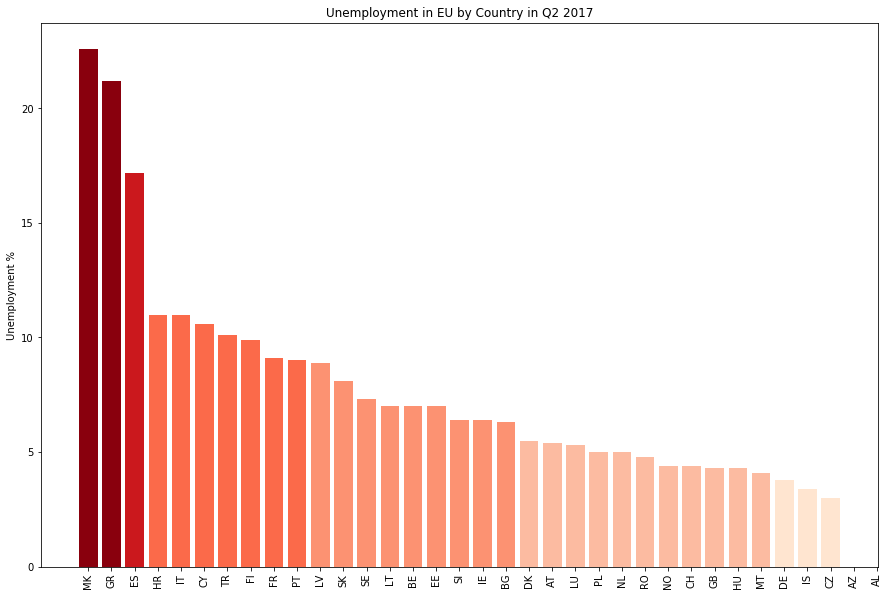

In [54]:
plt.figure(1)

sorted_df.sort_values(['Value'], ascending = False, inplace=True)
values = sorted_df['Value'].values
length = len(values)
names = sorted_df['COUNTRY_CODE'].values
plt.bar(range(0,length), values)
plt.xticks(range(0,length), names, rotation=90)

for i in range(0, length):
    nm = np.squeeze(sorted_df[sorted_df['COUNTRY_CODE'] == names[i]]['COUNTRY_CODE']);
    color = unemployment_colors_eu(nm)
    plt.bar(i,values[i], color=color)
    
plt.ylabel('Unemployment %')
plt.title('Unemployment in EU by Country in Q2 2017')

plt.show() 

##### Switzerland in comparison with other countries
Swiss unemployment is low -~5% compared to most others countries, it is on the top 7 european countries out of 35. 

#### Choropleth Map of Europe Unemployment

--> to see the map, go to <a href="hw3_data/map_europe_unemployment.html">map_europe_unemployment.html</a>

In [55]:
m = make_folium_map('hw3_data/europe2.topojson.json', 'objects.europe',
                    unemployment_colors_eu, 4.0, 21.0, colors_eu, 
                    [56,10], 3.5, '% Europe Unemployment in Q2 2017')

m.save('hw3_data/map_europe_unemployment.html')

m

### Comments:
1. We could observe that Macedonia and Greece, the countries with crisis, have high unemployment (as well as Spain).
2. Countries like Germany with a lot of money and stable economy, have very low unemployment.

---
## II -  Switzerland
### Load and clean the Swiss data from amstat
1. Downloaded the data as excel - Arbeitslosen- und Jugendarbeitslosenquote nach verschiedenen Kriterien.xlsx
2. Delete unnecessary columns
3. Add the canton code manually

In [56]:
swiss_df = pd.read_excel('hw3_data/Arbeitslosen- und Jugendarbeitslosenquote nach verschiedenen Kriterien.xlsx',skiprows=3)
swiss_df.columns = ['Canton','Na','Unemployment rate', 'Unemployed people']
swiss_df = swiss_df[['Canton','Unemployment rate']]
swiss_df['CODE'] = ['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']     
swiss_df.head()

,Canton,Unemployment rate,CODE
0,Zürich,3.3,ZH
1,Bern,2.4,BE
2,Luzern,1.7,LU
3,Uri,0.6,UR
4,Schwyz,1.7,SZ


### Explore the Data
1. Assign colors to classes.
2. show barplot to see the distrubution of unemployment per canton.

In [57]:
colors_swiss = ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']
thresh_swiss = [1.0      , 2.0      , 3.0      , 4.0      , 5.0      , 6.0     , 7, 8]

def unemployment_colors_swiss(state):
    """Maps Unemplpoyment value with colors."""
    val = swiss_df[swiss_df['CODE'] == state]['Unemployment rate']
    val = np.squeeze(val)
    length = len(colors_swiss)
    for i in range(0, length-1):
        if val < thresh_swiss[i]:
            return colors_swiss[i]
    return  colors_swiss[length-1]

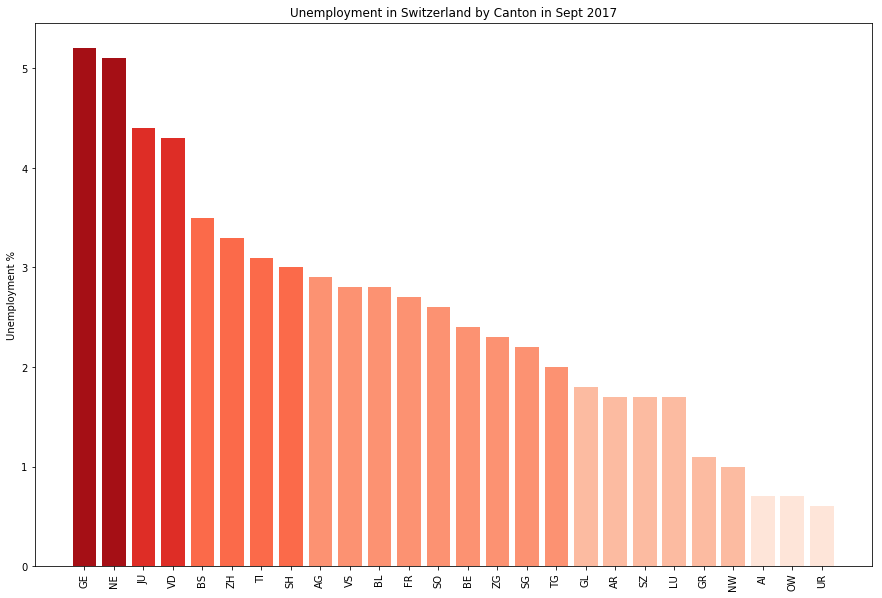

In [58]:
plt.figure(1)

swiss_df.sort_values(['Unemployment rate'], ascending = False, inplace=True)
values = swiss_df['Unemployment rate'].values
length = len(values)
names = swiss_df['CODE'].values
plt.bar(range(0,length), values)
plt.bar(3,values[3], color='purple') # set CH to purple
plt.xticks(range(0,length), names, rotation=90)

for i in range(0, length):
    nm = np.squeeze(swiss_df[swiss_df['CODE'] == names[i]]['CODE']);
    color = unemployment_colors_swiss(nm)
    plt.bar(i,values[i], color=unemployment_colors_swiss(nm))
    
plt.ylabel('Unemployment %')
plt.title('Unemployment in Switzerland by Canton in Sept 2017')

plt.show()

#### Choropleth Map of Swiss Unemployment

--> to see the map, go to <a href="hw3_data/map_swiss_unemployment.html">map_swiss_unemployment.html</a>

In [59]:
m = make_folium_map('hw3_data/ch-cantons_topo.json', 'objects.cantons',
                    unemployment_colors_swiss, 0.0, 6.0, colors_swiss,[46.9,8], 8, '% Swiss Unemployment in Sept 2017')

m.save('hw3_data/map_swiss_unemployment.html')

m

### Comments
1. We can observe, that the cantons close to the French border have significantly bigger unemployment.
2. Cantons in the middle have very small unemployment.

### Load another data from amstat, to create modified unemployment rate
The new data conatain 2 values, the unemployment people and the job seekers. We define the new unemployment ratio as 
job seekers - unemployment people / population. The population is computed from the previous dataframe.

In [60]:
swiss_df2 = pd.read_excel('hw3_data/1_3 Arbeitslose nach Berufsgruppen_ Geschlecht und Kantonen.xlsx',skiprows=3)
swiss_df2.columns = ['Canton','Na','Unemployment People', 'Job seekers']
swiss_df2 = swiss_df2[['Canton','Unemployment People', 'Job seekers']]
swiss_df2['CODE'] = ['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']     
swiss_df2['Population'] = np.floor(swiss_df2['Unemployment People'] *100 / swiss_df['Unemployment rate'])
swiss_df2['New Unemployed Ratio'] = ( swiss_df2['Job seekers'] -swiss_df2['Unemployment People'] )*100 / swiss_df2['Population']
swiss_df2.head()

,Canton,Unemployment People,Job seekers,CODE,Population,New Unemployed Ratio
0,Zürich,27225,34156,ZH,825000.0,0.840121
1,Bern,13658,18385,BE,569083.0,0.830635
2,Luzern,3885,6756,LU,228529.0,1.256296
3,Uri,112,257,UR,18666.0,0.776813
4,Schwyz,1455,2229,SZ,85588.0,0.904332


### Explore the modified unemployment data
1. Assign new colors to classes.
2. show barplot to see the distrubution of modified unemployment per canton.

In [61]:
colors_swiss2 = ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26']
thresh_swiss2 = [0.5      , 1.0      , 1.5      , 2.0      , 2.5      , 3.0     , 3.5]

def unemployment_colors_swiss2(state):
    """Maps Unemplpoyment value with colors."""
    val = swiss_df2[swiss_df2['CODE'] == state]['New Unemployed Ratio']
    val = np.squeeze(val)
    length = len(colors_swiss2)
    for i in range(0, length-1):
        if val < thresh_swiss2[i]:
            return colors_swiss2[i]
    return  colors_swiss2[length-1]

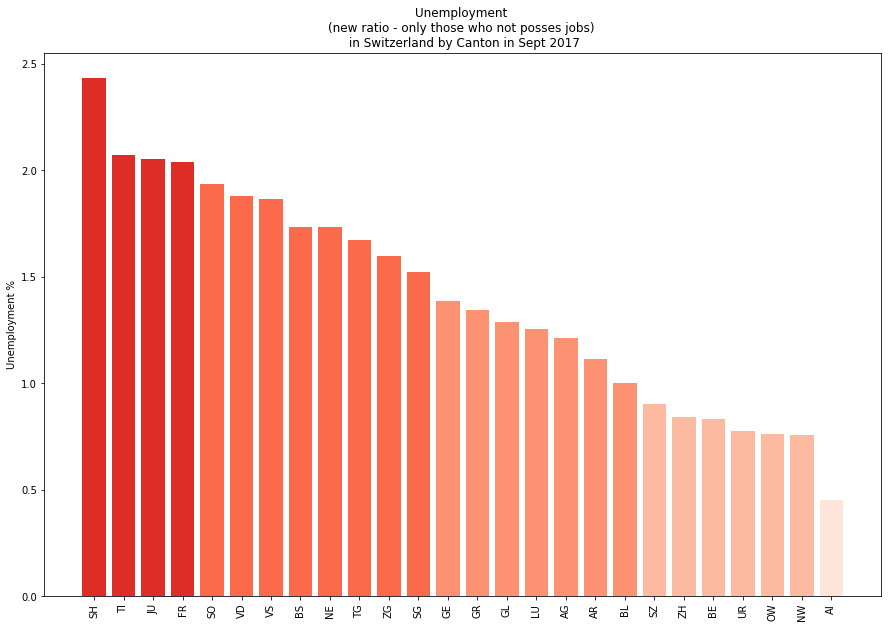

In [62]:
plt.figure(1)

swiss_df2.sort_values(['New Unemployed Ratio'], ascending = False, inplace=True)
values = swiss_df2['New Unemployed Ratio'].values
length = len(values)
names = swiss_df2['CODE'].values
plt.bar(range(0,length), values)
plt.bar(3,values[3], color='purple') # set CH to purple
plt.xticks(range(0,length), names, rotation=90)

for i in range(0, length):
    nm = np.squeeze(swiss_df2[swiss_df2['CODE'] == names[i]]['CODE']);
    color = unemployment_colors_swiss2(nm)
    plt.bar(i,values[i], color=color)
    
plt.ylabel('Unemployment %')
plt.title('Unemployment \n(new ratio - only those who not posses jobs) \n in Switzerland by Canton in Sept 2017')

plt.show()

#### Choropleth Map of Modified Swiss Unemployment

--> to see the map, go to <a href="hw3_data/map_swiss_unemployment2.html">map_swiss_unemployment2.html</a>

In [63]:
m = make_folium_map('hw3_data/ch-cantons_topo.json', 'objects.cantons',
                    unemployment_colors_swiss2, 0.0, 2.5, colors_swiss2,[46.9,8], 8, '% Swiss Unemployment (new ratio) in Sept 2017')
m.save('hw3_data/map_swiss_unemployment2.html')

m

### Comments
1. This modified unemployment shows how many "real" unemployed people are in siwzterland (people that don't have a job, not the ones that are looking for a new one).
2. As expected, Ticcino is high, as it is close to Italy, where they have similar problems.
3. In general all Non-German speaking cantons are high
4. Nethertheless, the maximum unemployment is ratio is around 2.5 % which is very low

### Load another data from amstat, to analyse foreign people in CH unemployment
The new data conatain number of foerigners/swiss people, from which we can see what is the percantage of foreginers in the whole unemployment. 

In [64]:
swiss_df3 = pd.read_excel('hw3_data/1_2 Arbeitslose und Stellensuchende nach geografischen Merkmalen.xlsx',skiprows=3)
swiss_df3.columns = ['Canton','Nationality','Na','Unemployment People']
swiss_df3 = swiss_df3[['Canton','Nationality','Unemployment People']]

all_unemployed = swiss_df3.query('Nationality=="Gesamt"')[['Canton','Unemployment People']]

foreign_unemployed = swiss_df3.query('Nationality=="Ausländer"')[['Canton','Unemployment People']]
all_unemployed.reset_index(inplace=True)
foreign_unemployed.reset_index(inplace=True)

all_unemployed['Foreign Unemployed Perc'] = foreign_unemployed['Unemployment People'] *100 / all_unemployed['Unemployment People']
all_unemployed['CODE'] = ['ZH','BE','LU','UR','SZ','OW','NW','GL','ZG','FR','SO','BS','BL','SH','AR','AI','SG','GR','AG','TG','TI','VD','VS','NE','GE','JU']     

### Explore the foreigners unemployment data

In [65]:
colors_swiss3 = ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']
thresh_swiss3 = [33       , 37       , 40       , 45       , 48       , 52       , 53, 60]

def unemployment_colors_swiss3(state):
    """Maps Unemplpoyment value with colors."""
    val = all_unemployed[all_unemployed['CODE'] == state]['Foreign Unemployed Perc']
    val = np.squeeze(val)
    length = len(colors_swiss3)
    for i in range(0, length-1):
        if val < thresh_swiss3[i]:
            return colors_swiss3[i]
    return  colors_swiss3[length-1]

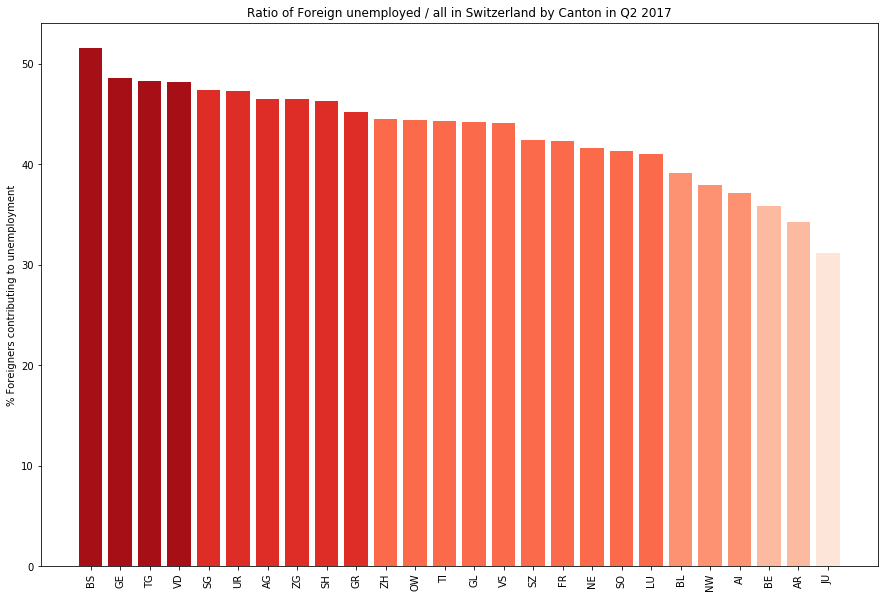

In [66]:
plt.figure(1)

all_unemployed.sort_values(['Foreign Unemployed Perc'], ascending = False, inplace=True)
values = all_unemployed['Foreign Unemployed Perc'].values
length = len(values)
names = all_unemployed['CODE'].values
plt.bar(range(0,length), values)
plt.xticks(range(0,length), names, rotation=90)

for i in range(0, length):
    nm = np.squeeze(all_unemployed[all_unemployed['CODE'] == names[i]]['CODE']);
    color = unemployment_colors_swiss3(nm)
    plt.bar(i,values[i], color=color)
    
plt.ylabel('% Foreigners contributing to unemployment')
plt.title('Ratio of Foreign unemployed / all in Switzerland by Canton in Q2 2017')

plt.show()

### Choropleth Map of Foreign Swiss Unemployment

--> to see the map, go to <a href="hw3_data/map_swiss_foreign_unemployment.html">map_swiss_foreign_unemployment.html</a>

In [67]:
m = make_folium_map('hw3_data/ch-cantons_topo.json', 'objects.cantons',
                    unemployment_colors_swiss3, 33.0, 52, colors_swiss3,[46.9,8], 8, '% Foreigners contributing to unemployment in CH in Sept 2017')
m.save('hw3_data/map_swiss_foreign_unemployment.html')

m

### Comments
1. We first notice that the foreigners unemployement is extremely high compared to the basic unemployement. 
1. Cantons that have borders with outside --> more foreigners working there --> they contribute more to the unemployment.

### Analysing Age in Unemployment
1. Combine all the above data in 1 dataframe.
2. Add age info from amstat

In [68]:
all_unemployed2 = all_unemployed[['Canton','Foreign Unemployed Perc', 'CODE']].copy()
#swiss_df2.reset_index(inplace=True)
all_unemployed2.set_index('CODE', inplace=True)
new_unemp = swiss_df2[['Canton','CODE','New Unemployed Ratio']].copy()
new_unemp.reset_index(inplace=True)
new_unemp = new_unemp[['Canton','CODE','New Unemployed Ratio']]
new_unemp.set_index('CODE', inplace=True)
all_data = all_unemployed2.copy()
swiss_df.set_index('CODE', inplace=True)
all_data['Unemployment Rate Only WT job'] = new_unemp['New Unemployed Ratio']
all_data['Regular Unemployment Rate'] = swiss_df[['Unemployment rate']]
all_data['Foreign Unemployed Rate'] = all_data['Foreign Unemployed Perc']/100
all_data = all_data[['Canton','Regular Unemployment Rate','Unemployment Rate Only WT job','Foreign Unemployed Rate']]
all_data.head()

,Canton,Regular Unemployment Rate,Unemployment Rate Only WT job,Foreign Unemployed Rate
CODE,,,,
BS,Basel-Stadt,3.5,1.735316,0.515195
GE,Genf,5.2,1.386923,0.485696
TG,Thurgau,2.0,1.674297,0.482341
VD,Waadt,4.3,1.878417,0.481725
SG,St. Gallen,2.2,1.521005,0.473641


In [69]:
swiss_df4 = pd.read_excel('hw3_data/1_2 Arbeitslose und Stellensuchende nach geografischen Merkmalen (1).xlsx',skiprows=3)
swiss_df4.columns = ['Canton','Age cat','Age cat name','Na','Unemployed People','Registered Jobsekers']
swiss_df4 = swiss_df4[['Canton','Age cat','Age cat name','Unemployed People','Registered Jobsekers']]

### Make Bar plot showing unemployment age distribution in cantons

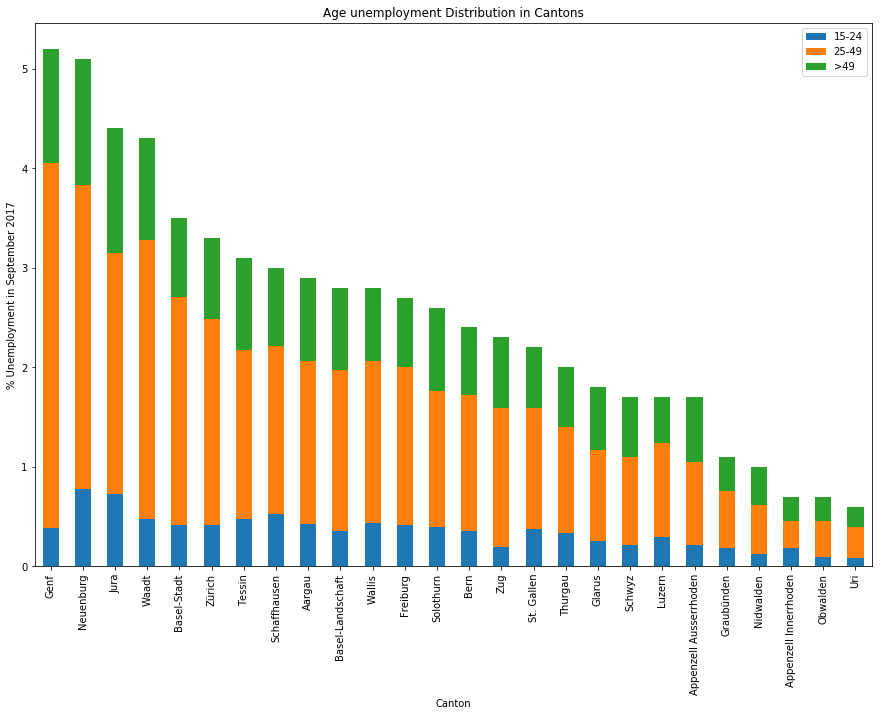

In [70]:
swiss_age_data = pd.DataFrame(columns=['Canton','15-24', '25-49','>49','sum'])
canton_names_nodupl = list(set(swiss_df4['Canton'].values))
canton_names_nodupl.remove('Gesamt')


for canton_name in canton_names_nodupl:
    multiplier = all_data[all_data['Canton'] == canton_name]['Regular Unemployment Rate'].values[0]
    val_15 = swiss_df4[swiss_df4['Canton']==canton_name]
    val_15 = val_15[val_15['Age cat']=='1']['Unemployed People'].values[0] / val_15[val_15['Age cat']=='Gesamt']['Unemployed People'].values[0]
    val_15 *=multiplier
    val_25 = swiss_df4[swiss_df4['Canton']==canton_name]
    val_25 = val_25[val_25['Age cat']=='2']['Unemployed People'].values[0] / val_25[val_25['Age cat']=='Gesamt']['Unemployed People'].values[0]
    val_25 *=multiplier
    val_49 = swiss_df4[swiss_df4['Canton']==canton_name]
    val_49 = val_49[val_49['Age cat']=='3']['Unemployed People'].values[0] / val_49[val_49['Age cat']=='Gesamt']['Unemployed People'].values[0]
    val_49 *=multiplier
    df = pd.DataFrame([[canton_name,val_15, val_25, val_49, multiplier]], columns=list(['Canton','15-24', '25-49','>49','sum' ]))
    swiss_age_data = pd.concat([swiss_age_data, df],ignore_index=True)
swiss_age_data.sort_values('sum', ascending = False, inplace=True)
swiss_age_data = swiss_age_data[['Canton','15-24', '25-49','>49']]
swiss_age_data.set_index('Canton', inplace=True)
plt.rcParams['figure.figsize'] = (15,10)
plt.figure(figsize=(4, 40))
swiss_age_data.plot.bar(stacked=True)
plt.title('Age unemployment Distribution in Cantons')
plt.ylabel('% Unemployment in September 2017')
plt.show()

### Comments: 
1. We can see, that the main age in unemployment is 25-49


### Bonus - Unemployment difference between Roestigraben
1. Count unemployment and whole population people in FR and GER parts of CH.
2. Compare the 2 numbers. 

In [71]:
fr_codes = ['JU','FR','VD', 'VS', 'NE','GE','BE']
ger_codes = ['BE','TG','AG','SG','AI','AR','SH','BL','BS','SO','ZG','GL','NW','OW','SZ','UR','LU','ZH']

fr_unemp_ppl=0
fr_total_ppl=0
for fr_code in fr_codes:
    fr_unemp_ppl+=swiss_df2[swiss_df2['CODE']==fr_code]['Unemployment People'].values[0]
    fr_total_ppl+=swiss_df2[swiss_df2['CODE']==fr_code]['Population'].values[0]
fr_unemp = fr_unemp_ppl*100/fr_total_ppl
print('Francofonique CH unemployment: ',fr_unemp ,'%')


ger_unemp_ppl=0
ger_total_ppl=0
for ger_code in ger_codes:
    ger_unemp_ppl+=swiss_df2[swiss_df2['CODE']==fr_code]['Unemployment People'].values[0]
    ger_total_ppl+=swiss_df2[swiss_df2['CODE']==fr_code]['Population'].values[0]
ger_unemp = ger_unemp_ppl*100/ger_total_ppl
print('Germanophone CH unemployment: ', ger_unemp,'%')

print('Difference in Roestigraben Unemployment is :  ' , fr_unemp - ger_unemp, '%')



Francofonique CH unemployment:  3.51327340386 %
Germanophone CH unemployment:  2.40000140577 %
Difference in Roestigraben Unemployment is :   1.11327199809 %


### Comments:
1. Only 1% of unemployment is not worth to move there and speak german...